In [1]:
import numpy as np
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
import pandas as pd
import anndata
import networkx as nx
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from torch_geometric.nn import GINConv, GCNConv, SAGEConv, GATConv
from torch_geometric.utils import train_test_split_edges
from RnaVeloDataset import RnaVeloDataset
import numpy as np
import matplotlib.pyplot as plt
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from math import sqrt

In [39]:
backbones = ["linear_simple"]
seed = [2]
trans_rate = [1, 5, 10]
split_rate = [0.1, 0.5, 1, 5, 10]
num_cells = [210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
root = 'data/'

combined = [(bb, sd, tr, sr, nc) for bb in backbones for sd in seed for tr in trans_rate for sr in split_rate for nc in num_cells]
data_list = []
adata_list = []

for item in combined:
    bb, sd, tr, sr, nc = item
    path = root + bb + "_" + str(sd) + "_" + str(tr) + "_" + str(sr) + "_" + str(nc)
    df = pd.read_csv(path + "_unspliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_unspliced = df.to_numpy()

    df = pd.read_csv(path + "_spliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_spliced = df.to_numpy()

    df = pd.read_csv(path + "_cell_info.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_obs = df

    adata = anndata.AnnData(X = csr_matrix(X_spliced),
                    obs = X_obs,
                    layers = dict(
                        unspliced = csr_matrix(X_unspliced),
                        spliced = csr_matrix(X_spliced)
                    ))

    adata_list.append(adata)
    continue

    # compute velocity
    scv.tl.velocity_graph(adata)

    # dimension reduction
    X_concat = np.concatenate((X_spliced,X_unspliced),axis=1)
    pca = PCA(n_components=30, svd_solver='arpack')
    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=30, svd_solver='arpack'))])
    features_pca = pipeline.fit_transform(X_concat)

    # predict gene expression data
    velo_matrix = adata.layers["velocity"].copy()
    X_pre = X_spliced + velo_matrix/np.linalg.norm(velo_matrix,axis=1)[:,None]*3

    X_pca_ori = pca.fit_transform(X_spliced)
    X_pca_pre = pca.transform(X_pre)
    velo_pca = X_pca_pre - X_pca_ori

    directed_conn = kneighbors_graph(X_pca_ori, n_neighbors=35, mode='connectivity', include_self=False).toarray()
    conn = directed_conn + directed_conn.T
    conn[conn.nonzero()[0],conn.nonzero()[1]] = 1

    x = torch.from_numpy(X_pca_ori.copy())
    edge_index = np.array(np.where(conn == 1))
    
    y = X_obs['sim_time'].to_numpy().reshape((-1, 1))
    scaler = MinMaxScaler((0, 200))
    scaler.fit(y)
    y = torch.FloatTensor(scaler.transform(y).reshape(-1))

    edge_attr = np.array([])
    for i in range(conn.shape[0]):
        indices = conn[i,:].nonzero()[0]
        diff = X_pca_ori[indices,:] - X_pca_ori[i,:]
        distance = np.linalg.norm(diff, axis=1, ord=2)[:,None]
        penalty = np.matmul(diff, velo_pca[i,:, None])/\
        (np.linalg.norm(velo_pca[i,:], ord=2) * distance)
        penalty = np.nan_to_num(penalty, 0)
        weights = (np.exp(penalty)/np.sum(np.exp(penalty))).squeeze()
        edge_attr = np.append(edge_attr, weights)
    edge_attr = torch.LongTensor(edge_attr)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    print(edge_index.shape)
    data_list.append(data)

Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
T

## One graph

In [68]:
def train(data):
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    data = data.to(device)
    optimizer.zero_grad()
    output = model(data)
    label = data.y.to(device)
    loss = torch.sqrt(mse(output, label))
    loss.backward()
    optimizer.step()

    return float(loss)

def test(data):
    model.eval()
    
    correct = []
    predict = []
    data = data.to(device)
    label = data.y.detach().cpu().numpy().reshape(-1)
    pred = model(data).detach().cpu().numpy().reshape(-1)
    # print(pred.shape)
    correct.extend(label)
    predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))

In [74]:
dataset = RnaVeloDataset(root='data/')
data = dataset[2]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = BaseModel(dataset.num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-4)

train_list = []
val_list = []

best_val_perf = test_perf = 0
for epoch in range(251):
    train_loss = train(data)
    train_acc = test(data)
    val_acc = test(data)
    test_acc = test(data)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc, test_acc))

    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 0.9842, Train: 0.8906, Val: 0.8906, Test: 0.8906
Epoch: 010, Loss: 0.7422, Train: 0.8036, Val: 0.8036, Test: 0.8036
Epoch: 020, Loss: 0.6768, Train: 0.7961, Val: 0.7961, Test: 0.7961
Epoch: 030, Loss: 0.6238, Train: 0.6882, Val: 0.6882, Test: 0.6882
Epoch: 040, Loss: 0.5921, Train: 0.6229, Val: 0.6229, Test: 0.6229
Epoch: 050, Loss: 0.5775, Train: 0.5989, Val: 0.5989, Test: 0.5989
Epoch: 060, Loss: 0.5717, Train: 0.5657, Val: 0.5657, Test: 0.5657
Epoch: 070, Loss: 0.5683, Train: 0.5670, Val: 0.5670, Test: 0.5670
Epoch: 080, Loss: 0.5670, Train: 0.5677, Val: 0.5677, Test: 0.5677
Epoch: 090, Loss: 0.5663, Train: 0.5656, Val: 0.5656, Test: 0.5656
Epoch: 100, Loss: 0.5658, Train: 0.5655, Val: 0.5655, Test: 0.5655
Epoch: 110, Loss: 0.5656, Train: 0.5640, Val: 0.5640, Test: 0.5640
Epoch: 120, Loss: 0.5653, Train: 0.5653, Val: 0.5653, Test: 0.5653
Epoch: 130, Loss: 0.5651, Train: 0.5651, Val: 0.5651, Test: 0.5651
Epoch: 140, Loss: 0.5650, Train: 0.5648, Val: 0.5648, Test: 0.

computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


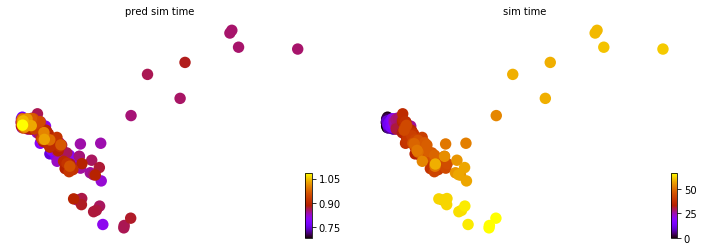

In [75]:
i = 2
model.eval()
adata = adata_list[i]
scv.tl.velocity_graph(adata)
adata.obs['pred_sim_time'] = model(data.to(device)).detach().cpu().numpy().reshape(-1)
scv.pl.scatter(adata, color=['pred_sim_time','sim_time'], color_map='gnuplot', legend_loc='on data')

In [76]:
np.array(adata.obs['pred_sim_time'])

array([0.9032101 , 0.8157097 , 0.88461536, 0.81480134, 0.8346839 ,
       0.8892654 , 0.7982675 , 0.86186314, 0.865836  , 0.88884795,
       0.8465373 , 0.8380264 , 0.96329594, 0.86008996, 0.72997695,
       0.7757679 , 0.93629104, 0.7995644 , 0.8985945 , 0.8704666 ,
       0.9212084 , 0.87053365, 0.84458923, 0.8584211 , 0.76112485,
       0.88652176, 0.78366864, 0.8660712 , 0.85894686, 0.8937815 ,
       0.82994306, 0.8836161 , 0.86487377, 0.85992736, 0.84399074,
       0.72872835, 0.7414192 , 0.91854805, 0.8891537 , 0.8463945 ,
       0.8189301 , 0.7101767 , 0.8688693 , 0.887306  , 0.83453715,
       0.79075146, 0.87763506, 0.9506554 , 0.8811238 , 0.90075094,
       1.0026149 , 0.82380915, 0.8173258 , 0.8691953 , 0.79177874,
       0.8345173 , 0.78435767, 0.90235484, 0.7768167 , 0.8250745 ,
       0.9657544 , 0.95237416, 0.8410452 , 0.8961941 , 0.83696723,
       0.9679832 , 0.84890693, 0.7865539 , 0.8986833 , 0.83332866,
       0.8766913 , 0.9530599 , 0.8195959 , 0.846602  , 0.75121

In [77]:
data.y

tensor([0.6569, 1.3135, 0.4778, 0.7166, 0.8360, 1.1643, 1.3732, 1.6717, 1.1046,
        1.0150, 0.5375, 1.5821, 0.0000, 0.3584, 0.2686, 0.0301, 0.6569, 1.4628,
        1.3732, 1.9105, 1.2538, 0.4480, 1.6717, 0.3584, 0.5375, 0.6270, 0.4778,
        1.7612, 0.0000, 1.8806, 1.2538, 0.1791, 2.0000, 0.6270, 1.3135, 0.2388,
        0.0898, 0.1196, 0.0000, 1.2837, 1.3135, 0.5375, 1.8806, 1.3732, 1.3135,
        0.7464, 1.8806, 0.6569, 1.2240, 0.4480, 0.0301, 1.0747, 0.8061, 1.1046,
        1.2837, 0.4778, 0.1196, 1.1643, 0.8360, 0.1196, 0.2985, 1.1344, 0.1492,
        1.1643, 0.0000, 1.1046, 1.2240, 0.3883, 0.0000, 0.7464, 0.6270, 0.4778,
        1.1643, 1.1941, 1.0150, 0.6867, 0.5076, 0.8957, 0.0898, 1.2837, 0.7464,
        2.0000, 0.0000, 1.0449, 0.6867, 1.1344, 1.9105, 0.2686, 0.7166, 0.0301,
        1.3434, 0.1791, 1.5523, 0.7166, 0.2089, 1.1344, 1.4329, 0.0000, 1.6120,
        0.6867, 0.2089, 1.1046, 0.9554, 0.4778, 1.7612, 0.6867, 1.7314, 0.8360,
        1.4329, 0.6867, 1.1046, 1.6418, 

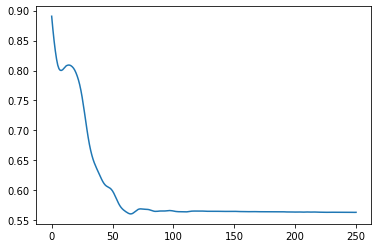

In [79]:
plt.plot(train_list)
plt.show()

## Batch

In [18]:
dataset = RnaVeloDataset(root='data/')
len(dataset)

150

In [58]:
def train():
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = torch.sqrt(mse(output, label))
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        pred = model(data).detach().cpu().numpy().reshape(-1)
        # print(pred.shape)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))


In [66]:
dataset = RnaVeloDataset(root='data/')
batch_size = 5
train_loader = DataLoader(dataset[:120], batch_size=batch_size)
val_loader = DataLoader(dataset[120:135], batch_size=batch_size)
test_loader = DataLoader(dataset[135:160], batch_size=1)

data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = BaseModel(dataset.num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-4, weight_decay=0.01)

best_val_perf = test_perf = 0

train_list = []
val_list = []
for epoch in range(251):
    train_loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc, test_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 1.2105, Train: 0.9257, Val: 0.9453, Test: 1.0200
Epoch: 010, Loss: 0.7594, Train: 0.7541, Val: 0.9776, Test: 1.1995
Epoch: 020, Loss: 0.6624, Train: 0.6915, Val: 0.8906, Test: 1.0623
Epoch: 030, Loss: 0.6181, Train: 0.6030, Val: 0.7469, Test: 0.9016
Epoch: 040, Loss: 0.5959, Train: 0.5912, Val: 0.6775, Test: 0.7768
Epoch: 050, Loss: 0.5787, Train: 0.6336, Val: 0.7698, Test: 0.8413
Epoch: 060, Loss: 0.5731, Train: 0.6319, Val: 0.7455, Test: 0.8199
Epoch: 070, Loss: 0.5734, Train: 0.5863, Val: 0.6197, Test: 0.6466
Epoch: 080, Loss: 0.5658, Train: 0.5728, Val: 0.6216, Test: 0.6642
Epoch: 090, Loss: 0.5637, Train: 0.5611, Val: 0.5958, Test: 0.6329
Epoch: 100, Loss: 0.5635, Train: 0.5629, Val: 0.6029, Test: 0.6383
Epoch: 110, Loss: 0.5634, Train: 0.5710, Val: 0.6296, Test: 0.6602
Epoch: 120, Loss: 0.5633, Train: 0.5558, Val: 0.5937, Test: 0.6265
Epoch: 130, Loss: 0.5634, Train: 0.5591, Val: 0.6046, Test: 0.6306
Epoch: 140, Loss: 0.5627, Train: 0.5641, Val: 0.6099, Test: 0.

Batch(batch=[260], edge_attr=[3232], edge_index=[2, 3232], x=[260, 30], y=[260])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


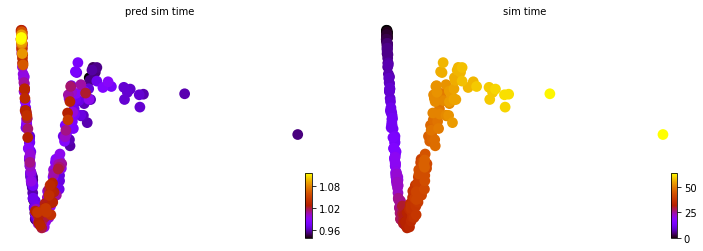

Batch(batch=[270], edge_attr=[3354], edge_index=[2, 3354], x=[270, 30], y=[270])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


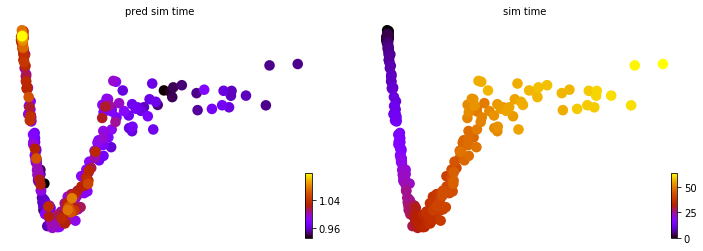

Batch(batch=[280], edge_attr=[3476], edge_index=[2, 3476], x=[280, 30], y=[280])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


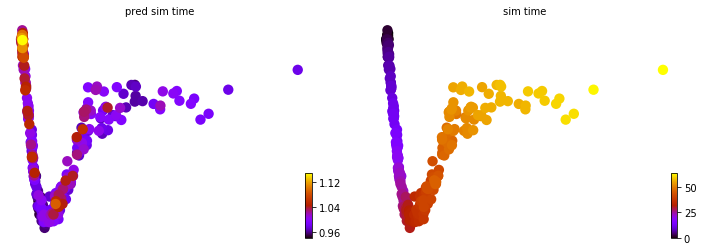

Batch(batch=[290], edge_attr=[3602], edge_index=[2, 3602], x=[290, 30], y=[290])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


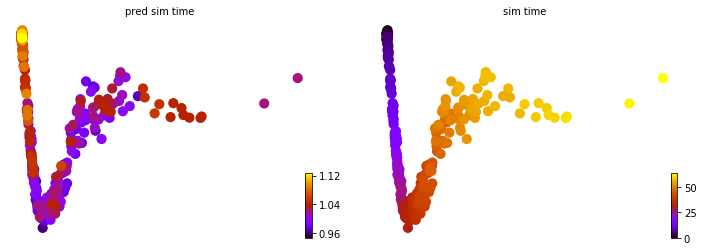

Batch(batch=[300], edge_attr=[3744], edge_index=[2, 3744], x=[300, 30], y=[300])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


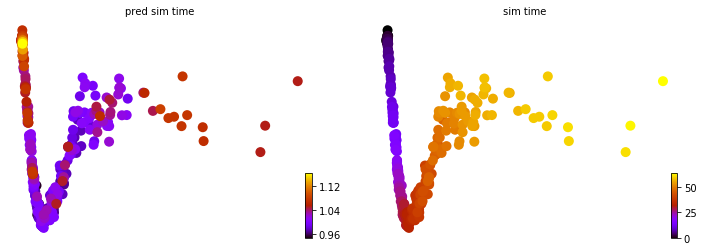

Batch(batch=[210], edge_attr=[2612], edge_index=[2, 2612], x=[210, 30], y=[210])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


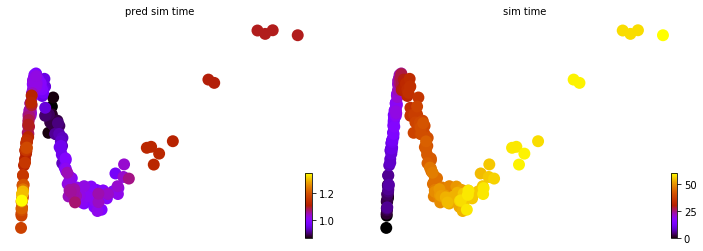

Batch(batch=[220], edge_attr=[2764], edge_index=[2, 2764], x=[220, 30], y=[220])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


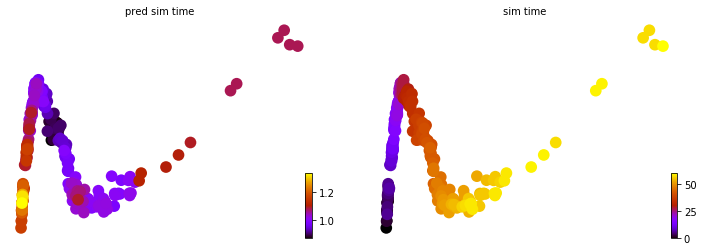

Batch(batch=[230], edge_attr=[2908], edge_index=[2, 2908], x=[230, 30], y=[230])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


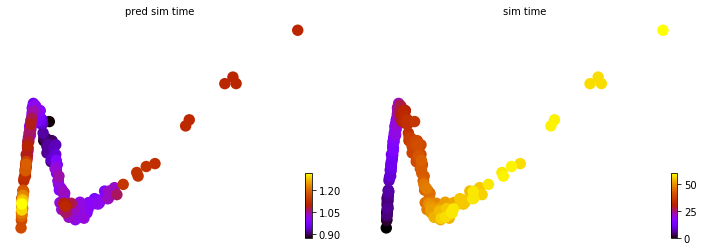

Batch(batch=[240], edge_attr=[3012], edge_index=[2, 3012], x=[240, 30], y=[240])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


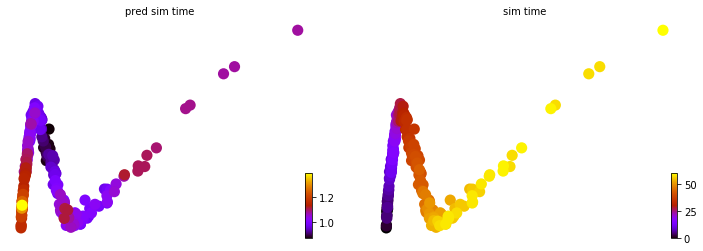

Batch(batch=[250], edge_attr=[3210], edge_index=[2, 3210], x=[250, 30], y=[250])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


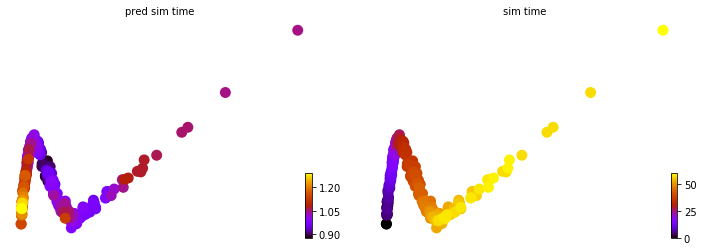

Batch(batch=[260], edge_attr=[3244], edge_index=[2, 3244], x=[260, 30], y=[260])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


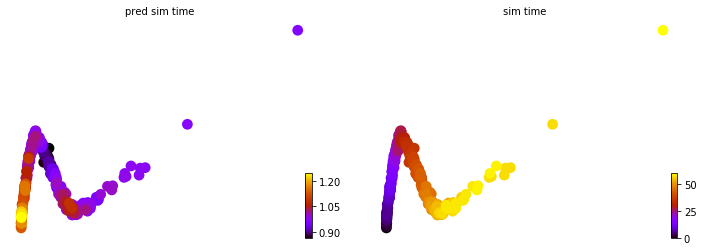

Batch(batch=[270], edge_attr=[3392], edge_index=[2, 3392], x=[270, 30], y=[270])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


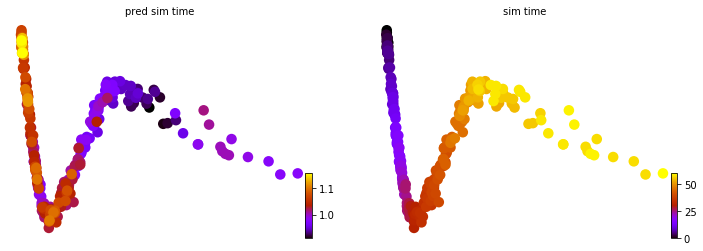

Batch(batch=[280], edge_attr=[3476], edge_index=[2, 3476], x=[280, 30], y=[280])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


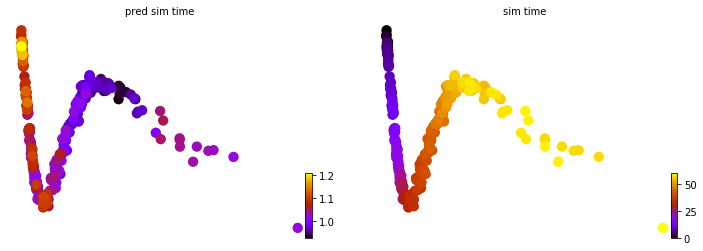

Batch(batch=[290], edge_attr=[3586], edge_index=[2, 3586], x=[290, 30], y=[290])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


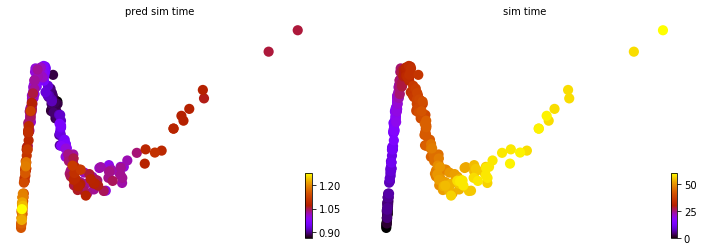

Batch(batch=[300], edge_attr=[3694], edge_index=[2, 3694], x=[300, 30], y=[300])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


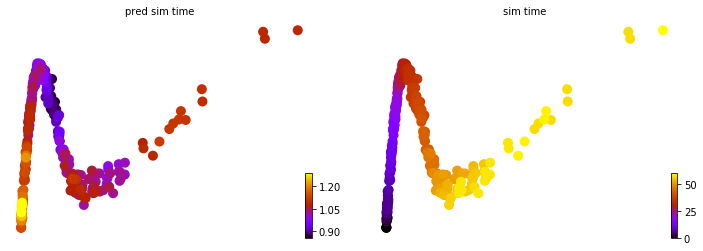

In [60]:
i = 135
model.eval()
for data in test_loader:
    print(data)
    adata = adata_list[i]
    scv.tl.velocity_graph(adata)
    adata.obs['pred_sim_time'] = model(data.to(device)).detach().cpu().numpy().reshape(-1)
    i += 1
    scv.pl.scatter(adata, color=['pred_sim_time','sim_time'], color_map='gnuplot', legend_loc='on data')

In [61]:
np.array(adata.obs['pred_sim_time'])

array([1.0801146 , 1.03992   , 0.8730745 , 1.1132282 , 1.1544441 ,
       1.1132283 , 0.8664046 , 1.0153527 , 1.0358782 , 1.0330604 ,
       1.0463092 , 1.1028206 , 1.154238  , 1.0278373 , 1.034245  ,
       1.0081673 , 1.0511044 , 1.0415606 , 1.0840299 , 1.0173776 ,
       1.0378542 , 1.0189114 , 1.1774509 , 1.042565  , 1.1777358 ,
       1.1667873 , 1.1861835 , 1.0352952 , 0.98354554, 0.87867904,
       0.9664061 , 1.1542883 , 0.9681522 , 0.87259746, 0.91531396,
       1.2896619 , 1.0006936 , 1.0185571 , 1.0915799 , 1.021416  ,
       1.0595075 , 1.0121994 , 1.1445735 , 0.9351815 , 0.9598338 ,
       1.0001764 , 1.0577582 , 1.1205192 , 1.1971035 , 1.0477905 ,
       1.0316553 , 1.0476713 , 0.9589461 , 1.0706646 , 1.0877506 ,
       1.0328405 , 0.9872419 , 1.0121292 , 1.0944469 , 1.0705523 ,
       1.0284698 , 1.027838  , 1.0474946 , 0.8724662 , 1.0303863 ,
       0.89459395, 0.98459536, 1.2159282 , 1.0599511 , 0.98469895,
       0.87927693, 1.2871095 , 0.8825932 , 1.1213591 , 0.98954

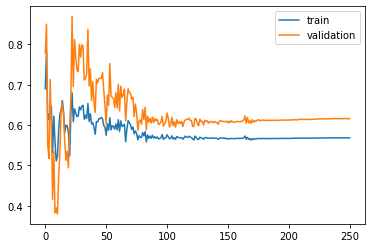

In [62]:
plt.plot(train_list)
plt.plot(val_list)
plt.legend(['train', 'validation'], loc='uppder right')
plt.show()

In [63]:
data.y

tensor([1.9344, 1.6066, 1.3444, 1.9672, 0.1967, 1.9017, 1.2460, 1.9344, 1.7377,
        0.5576, 1.7050, 0.3278, 0.1967, 0.5576, 1.9344, 0.8526, 0.5576, 1.9344,
        0.5904, 0.4920, 1.5738, 1.5083, 0.0331, 1.0821, 0.0658, 0.2295, 0.1967,
        1.5738, 0.8198, 1.1804, 1.0493, 0.1967, 0.9837, 1.3771, 1.4427, 0.1314,
        0.7543, 1.9344, 0.4264, 0.5576, 1.6066, 1.7377, 0.0000, 1.2132, 1.0165,
        1.9344, 0.4592, 0.3606, 0.0000, 0.5904, 0.6559, 1.7050, 1.0493, 1.7705,
        1.9672, 1.5083, 0.9837, 1.8033, 1.7377, 1.7050, 1.6722, 1.8689, 0.7543,
        1.2788, 0.5248, 1.2132, 0.8198, 0.3278, 0.4264, 0.7543, 1.2788, 0.0986,
        1.3116, 0.3278, 0.7215, 0.5248, 1.8689, 1.8361, 1.7377, 0.9182, 1.0165,
        1.3116, 1.1149, 1.0165, 0.5576, 1.4099, 0.1314, 1.9017, 0.0000, 1.3116,
        1.6066, 1.6394, 1.2460, 1.4427, 0.6559, 0.8198, 0.4920, 1.2788, 1.5410,
        0.3278, 0.6887, 1.5083, 0.3606, 2.0000, 0.9837, 0.5904, 1.9017, 1.7377,
        1.9344, 0.6559, 1.4099, 1.2788, 

In [64]:
np.var(np.array(adata.obs['pred_sim_time']))

0.0078932755

In [65]:
np.var(np.array(data.y.cpu()))

0.36453086